
Starting MCMC sampling for Change Point Model...


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, sigma_1, mu_2, sigma_2]


c:\Users\Administrator\Desktop\10 Acadamy\week 
10\Change-point-analysis-and-statistical-modelling-of-time-series-data\.venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\Administrator\Desktop\10 Acadamy\week 
10\Change-point-analysis-and-statistical-modelling-of-time-series-data\.venv\Lib\site-packages\pytensor\scalar\basi
c.py:2094: RuntimeWarning: divide by zero encountered in divide
  return x / y

c:\Users\Administrator\Desktop\10 Acadamy\week 
10\Change-point-analysis-and-statistical-modelling-of-time-series-data\.venv\Lib\site-packages\pytensor\scalar\basi
c.py:2094: RuntimeWarning: overflow encountered in divide
  return x / y

c:\Users\Administrator\Desktop\10 Acadamy\week 
10\Change-point-analysis-and-statistical-modelling-of-time-series-data\.venv\Lib\site-packages\pytensor\scalar\basi
c.py:3297: RuntimeWarning: overflow encountered in scalar multiply
  return x * x

c:\Users\Administrator\Desktop\10 Acadamy\week 
10\Change-point-analysis-and-statistical-modelling-of-time-series-data\.venv\Lib\site-packages\pytensor\tensor\elem
wise.py:1411: RuntimeWarning: invalid value encountered in reduce
  out = self.ufunc.reduce(input, axis=axis, dtype=acc_dtype)

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 18068 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Sampling complete.


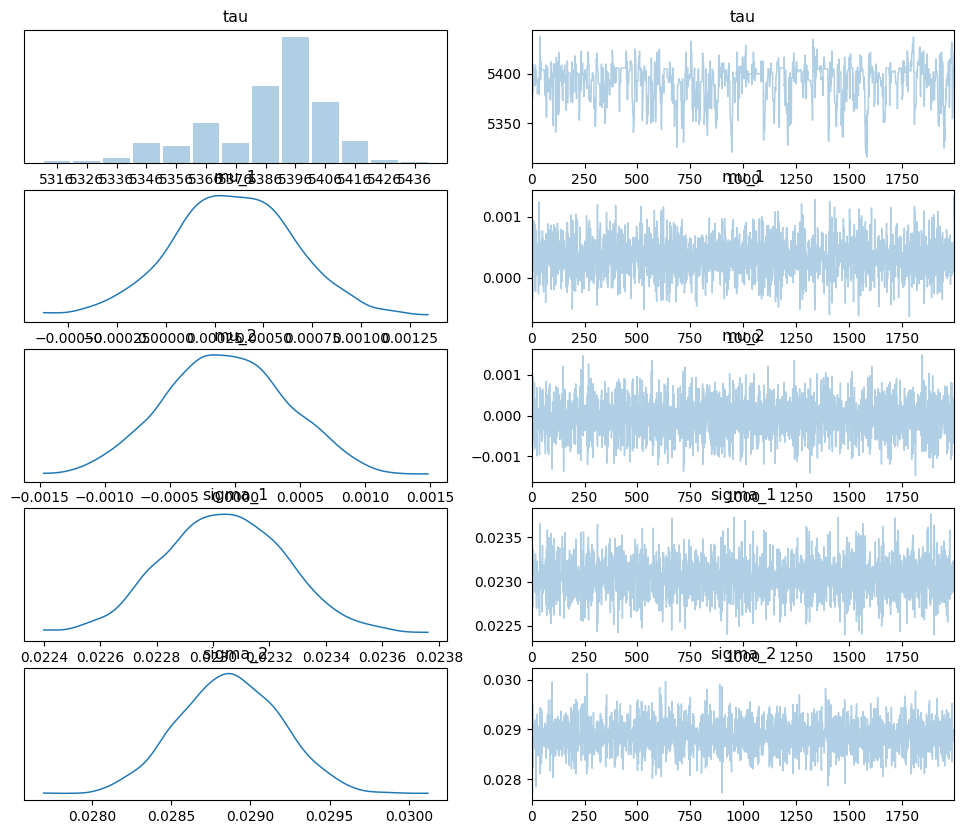


--- Model Interpretation and Insights ---
The most probable change point index (tau) is: 5406
This corresponds to the date: 2008-08-21

Quantitative Impact Analysis:
Before the change point (mu_1): Mean Log Return = 0.0003, Volatility (sigma_1) = 0.0230
After the change point (mu_2): Mean Log Return = -0.0001, Volatility (sigma_2) = 0.0289


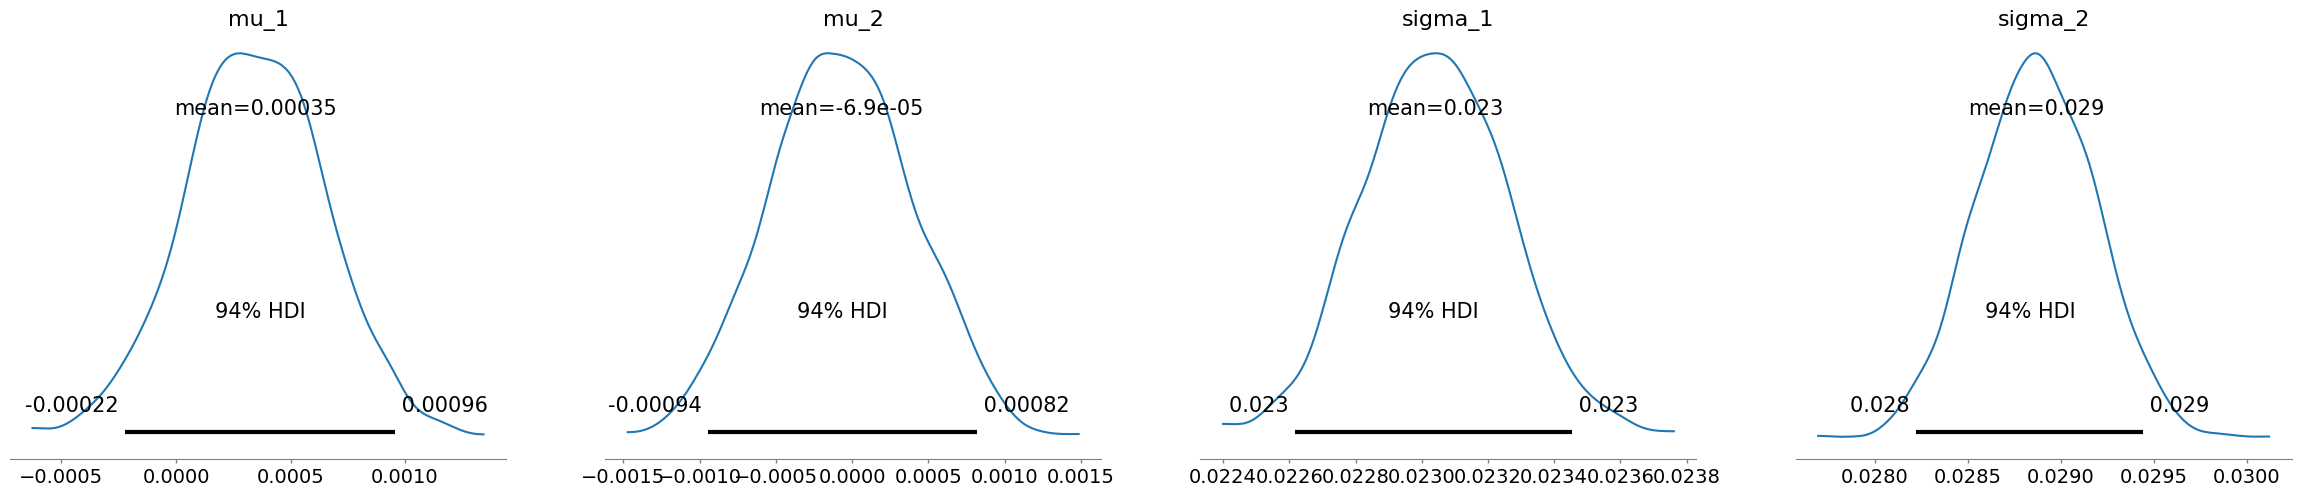

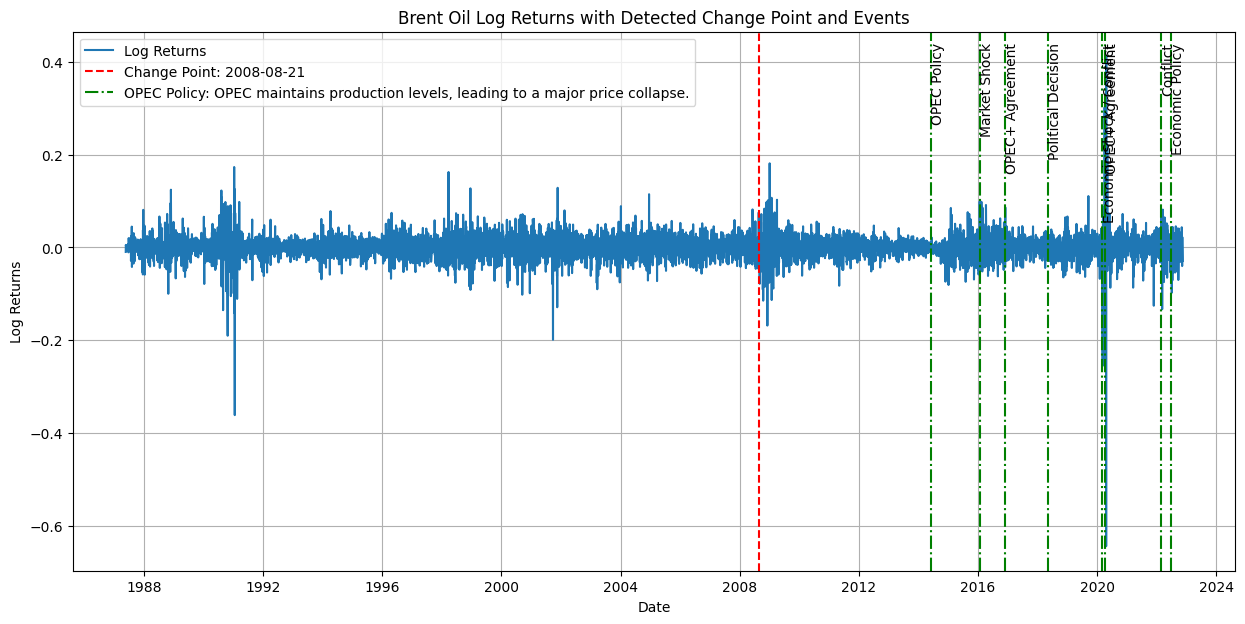

In [2]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load and preprocess data (as in Task 1)
def load_and_preprocess_data(file_path):
    """
    Loads data, converts date, calculates log returns, and returns the preprocessed DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
        df.dropna(inplace=True)
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred during data preprocessing: {e}")
        return None

# Compile event data (as in Task 1)
def compile_event_data():
    """
    Compiles a structured dataset of key geopolitical and economic events.
    """
    events = [
        {'date': pd.to_datetime('2014-06-01'), 'type': 'OPEC Policy', 'description': 'OPEC maintains production levels, leading to a major price collapse.'},
        {'date': pd.to_datetime('2016-01-20'), 'type': 'Market Shock', 'description': 'Brent crude prices hit a 12-year low below $30 per barrel.'},
        {'date': pd.to_datetime('2016-12-01'), 'type': 'OPEC+ Agreement', 'description': 'OPEC and non-OPEC countries agree on joint production cuts.'},
        {'date': pd.to_datetime('2018-05-08'), 'type': 'Political Decision', 'description': 'U.S. withdraws from the Iran nuclear deal and reimposes sanctions.'},
        {'date': pd.to_datetime('2020-03-01'), 'type': 'Economic Shock / Conflict', 'description': 'COVID-19 pandemic and a Saudi-Russia price war.'},
        {'date': pd.to_datetime('2020-04-12'), 'type': 'OPEC+ Agreement', 'description': 'OPEC+ agrees to a historic production cut to stabilize the market.'},
        {'date': pd.to_datetime('2022-02-24'), 'type': 'Conflict', 'description': 'Russian invasion of Ukraine sends oil prices soaring.'},
        {'date': pd.to_datetime('2022-07-01'), 'type': 'Economic Policy', 'description': 'Central bank rate hikes fuel recession fears.'},
    ]
    return pd.DataFrame(events)

# --- Main Script for Task 2 ---
if __name__ == "__main__":
    file_path = '../data/raw/BrentOilPrices.csv'  # Replace with your file path
    df = load_and_preprocess_data(file_path)
    event_df = compile_event_data()

    if df is not None:
        # --- Building the Bayesian Change Point Model (PyMC) ---
        returns = df['Log_Returns'].values
        n_points = len(returns)

        with pm.Model() as change_point_model:
            # Define the Switch Point (tau)
            # Discrete uniform prior over the possible indices of the time series
            tau = pm.DiscreteUniform('tau', lower=0, upper=n_points - 1)

            # Define the "Before" and "After" Parameters
            # Priors for the mean and standard deviation of log returns
            # Use a HalfNormal for standard deviation since it must be positive
            mu_1 = pm.Normal('mu_1', mu=0, sigma=0.01)
            sigma_1 = pm.HalfNormal('sigma_1', sigma=1)

            mu_2 = pm.Normal('mu_2', mu=0, sigma=0.01)
            sigma_2 = pm.HalfNormal('sigma_2', sigma=1)

            # Use a Switch Function to select the correct parameters based on tau
            # The `pm.math.switch` function is key here
            idx = np.arange(n_points)
            mu = pm.math.switch(tau > idx, mu_1, mu_2)
            sigma = pm.math.switch(tau > idx, sigma_1, sigma_2)

            # Define the Likelihood
            # Our observed data `returns` is modeled as a Normal distribution
            # with the mean `mu` and standard deviation `sigma` determined by the switch function.
            likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=returns)
            
            # --- Run the Sampler (MCMC) ---
            print("\nStarting MCMC sampling for Change Point Model...")
            idata = pm.sample(draws=2000, tune=1000, chains=1, cores=1, return_inferencedata=True)
            print("Sampling complete.")

        # --- Interpreting the Model Output ---
        
        # Check for Convergence
        az.summary(idata, var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'], hdi_prob=0.95)
        az.plot_trace(idata, var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'])
        plt.show()

        # Identify the Change Point
        tau_posterior = idata.posterior['tau'].values.flatten()
        # Find the value with the highest frequency
        most_probable_tau_index = int(pd.Series(tau_posterior).mode()[0])
        change_point_date = df.index[most_probable_tau_index]

        print("\n--- Model Interpretation and Insights ---")
        print(f"The most probable change point index (tau) is: {most_probable_tau_index}")
        print(f"This corresponds to the date: {change_point_date.strftime('%Y-%m-%d')}")

        # Quantify the Impact
        mu_1_mean = idata.posterior['mu_1'].mean().item()
        mu_2_mean = idata.posterior['mu_2'].mean().item()
        sigma_1_mean = idata.posterior['sigma_1'].mean().item()
        sigma_2_mean = idata.posterior['sigma_2'].mean().item()
        
        print("\nQuantitative Impact Analysis:")
        print(f"Before the change point (mu_1): Mean Log Return = {mu_1_mean:.4f}, Volatility (sigma_1) = {sigma_1_mean:.4f}")
        print(f"After the change point (mu_2): Mean Log Return = {mu_2_mean:.4f}, Volatility (sigma_2) = {sigma_2_mean:.4f}")
        
        # Plot posterior distributions for quantitative comparison
        az.plot_posterior(idata, var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2'])
        plt.show()

        # --- Associate Changes with Causes and Visualize ---
        # Plot the log returns with the detected change point
        plt.figure(figsize=(15, 7))
        plt.plot(df.index, returns, label='Log Returns')
        plt.axvline(x=change_point_date, color='r', linestyle='--', label=f'Change Point: {change_point_date.strftime("%Y-%m-%d")}')
        
        # Add event markers for context
        for index, event in event_df.iterrows():
            plt.axvline(x=event['date'], color='g', linestyle='-.', label=f"{event['type']}: {event['description']}" if index==0 else None)
            plt.text(event['date'], plt.ylim()[1] * 0.95, event['type'], rotation=90, va='top')
        
        plt.title("Brent Oil Log Returns with Detected Change Point and Events")
        plt.xlabel("Date")
        plt.ylabel("Log Returns")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Formulate Hypotheses based on the date
        event_match = event_df[(event_df['date'] - change_point_date).dt.days.abs() < 90] # within 3 months
        if not event_match.empty:
            print("\n--- Hypothesis Formulation ---")
            print("The detected change point is statistically significant and its date is close to the following event(s):")
            for _, event in event_match.iterrows():
                print(f"- **Event Date:** {event['date'].strftime('%Y-%m-%d')}")
                print(f"  **Event Type:** {event['type']}")
                print(f"  **Description:** {event['description']}")
                print("  **Hypothesis:** This event likely triggered a structural shift in the market. The model quantifies this shift as a change in the average daily log return from "
                      f"{mu_1_mean:.4f} to {mu_2_mean:.4f} and a change in volatility from {sigma_1_mean:.4f} to {sigma_2_mean:.4f}.")
